In [3]:
!git clone https://github.com/davda54/sam

fatal: destination path 'sam' already exists and is not an empty directory.


In [4]:
from MegaSAM.mega_adaptive_sam import MegaSAM
import sys; sys.path.append("..")

sys.path.append("sam")
from sam import SAM

In [5]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm, trange
from sklearn import datasets
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"

c:\Users\szilv\OneDrive\Dokumentumok\summer_2022\summer_venv\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
c:\Users\szilv\OneDrive\Dokumentumok\summer_2022\summer_venv\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


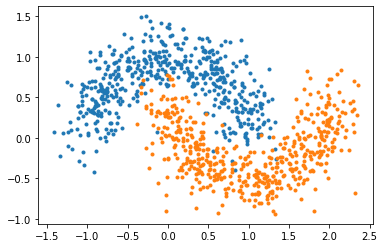

In [6]:
N = 1000

def data_gen():
    all_data = []
    X,y = datasets.make_moons(n_samples=N, shuffle=True, noise=0.2, random_state=1234)
    y = np.reshape(y, (len(y),1))
    for index, point in enumerate(X):
        point=np.reshape(point, (2,1))
        all_data.append([torch.tensor(point), y[index][0]])
    return all_data
  
all_data = data_gen()

zeros_x = [all_data[i][0][0] for i in range(N) if not all_data[i][1]]
zeros_y = [all_data[i][0][1] for i in range(N) if not all_data[i][1]]

ones_x = [all_data[i][0][0] for i in range(N) if all_data[i][1]]
ones_y = [all_data[i][0][1] for i in range(N) if all_data[i][1]]

plt.plot(zeros_x, zeros_y, '.')
plt.plot(ones_x, ones_y, '.')

train_data = all_data[:N*8//10]
test_data = all_data[N*8//10:]
batch_size = 1000
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [7]:
from tqdm.notebook import tqdm, trange

output1 = 10

model = nn.Sequential(
    nn.Linear(2, output1),
    nn.ReLU(),
    nn.Linear(output1, 1)
)

def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

num_params = get_n_params(model)
M = torch.ones(num_params)

epochs = 1000

base_optimizer = torch.optim.SGD
optimizer = MegaSAM(model.parameters(), base_optimizer, M, eta2=0.01, alpha=0.05, lr = 0.01)
criterion = nn.BCEWithLogitsLoss()

for epoch in trange(epochs):
    for points, labels in train_loader:
        
        optimizer.zero_grad()

        x = points[:,:,0].float()
        x = x.to(device)
        labels = labels[:,None].double()

        def closure():
          loss = criterion(model(x), labels)
          loss.backward()
          return loss

        y = model(x)
        loss = criterion(y, labels)
        
        loss.backward()
        optimizer.step(closure)


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\Users\szilv\OneDrive\Dokumentumok\summer_2022\Summer-2022\MegaAdaptiveSAM\MegaSAM\mega_adaptive_sam.py:88: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2985.)
  norm = torch.sqrt(M_inv.T @ grads_flattened**2)


TypeError: _reshape() takes 2 positional arguments but 3 were given

In [ ]:
correct_test = 0
with torch.no_grad():
        # Iterate through test set minibatchs 
        for numbers2, labels2 in test_loader:
            numbers2 = numbers2
            labels2 = labels2.double()[:,None]
            # Forward pass
            x2 = numbers2[:,:,0].float()
            y2 = model(x2)
            predictions2 = ((y2>0)*1)
            correct_test += torch.sum((predictions2 == labels2).float())
print(f'Test accuracy: {correct_test/len(test_data)}')

Test accuracy: 0.8799999952316284


tensor([[ 3.1421e-07, -2.5047e-08, -7.8260e-05,  ..., -7.6859e-05,
          9.9927e-05,  3.3073e-04],
        [-2.5047e-08,  1.9970e-09,  6.2075e-06,  ...,  6.0816e-06,
         -7.9186e-06, -2.6398e-05],
        [-7.8260e-05,  6.2075e-06,  3.2281e-02,  ...,  3.0863e-02,
         -4.3707e-02, -9.0416e-02],
        ...,
        [-7.6859e-05,  6.0816e-06,  3.0863e-02,  ...,  5.0007e-02,
         -4.2700e-02, -5.7711e-02],
        [ 9.9927e-05, -7.9186e-06, -4.3707e-02,  ..., -4.2700e-02,
          6.1959e-02,  1.1227e-01],
        [ 3.3073e-04, -2.6398e-05, -9.0416e-02,  ..., -5.7711e-02,
          1.1227e-01,  4.7980e-01]])


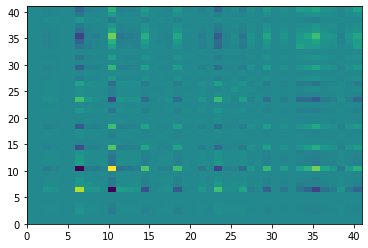

In [ ]:
def _flatten_and_together(list_of_tensors):
    new_list = []
    for tensor in list_of_tensors:
        new_list.append(torch.flatten(tensor))
    return torch.cat(new_list)

correct_test = 0
fischer_test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

fischer = torch.zeros((41, 41))

# Iterate through test set minibatchs 
for numbers2, labels2 in fischer_test_loader:
    labels2 = labels2.double()[:,None]
    # Forward pass
    x2 = numbers2[:,:,0].float()
    y2 = model(x2)
    labels = torch.bernoulli(torch.sigmoid(y2.detach()))
    loss_fn = nn.BCEWithLogitsLoss()
    loss = loss_fn(y2, labels)
    #model.zero_grad()
    loss.backward()
    g = _flatten_and_together([p.grad for p in model.parameters()])
    #print(f"shape of g: {g.size()}")
    #print(f"g: {g}")
    #print(f"izé: {g[None, :] * g[:, None]}")
    fischer += g[None, :] * g[:, None]
fischer = fischer / N
print(fischer)


plt.pcolor(fischer.numpy())


In [ ]:
optimizer.M

tensor([1.0380, 1.0380, 1.0380, 1.0380, 1.0380, 1.0380, 1.0381, 1.0407, 1.0381,
        1.0383, 1.0383, 1.0395, 1.0381, 1.0382, 1.0382, 1.0381, 1.0382, 1.0380,
        1.0382, 1.0381, 1.0380, 1.0381, 1.0380, 1.0387, 1.0380, 1.0395, 1.0382,
        1.0386, 1.0382, 1.0382, 1.0380, 1.0383, 1.0380, 1.0460, 1.0381, 1.0444,
        1.0386, 1.0387, 1.0382, 1.0387, 1.0393])